# Meta learing baseline evaluation

To improve RI model performance using meta-learning, first, we evaluate the baseline performance that shows how good model without meta-learning trained on a certain region environment controls on other environments. For example, we have four simulators that is coresponding to one prepared region. For example, we have four simulators that are corresponding to prepared regions. Once we trained our RI model in region 1, then we evaluate how well the trained model performers in other regions, 2, 3, and 4.

## Libraries

In [1]:
# get CityLearn from github
!rm -rf ./CityLearn/
!git clone https://github.com/intelligent-environments-lab/CityLearn.git

Cloning into 'CityLearn'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 783 (delta 10), reused 26 (delta 2), pack-reused 736
Receiving objects: 100% (783/783), 36.62 MiB | 21.38 MiB/s, done.
Resolving deltas: 100% (439/439), done.


In [2]:
!pip install stable_baselines3

     |████████████████████████████████| 153kB 14.1MB/s 


In [3]:
from google.colab import drive
drive.mount('/gdrive')
!ls /gdrive

Mounted at /gdrive
MyDrive


In [4]:
# Loading libraries
import sys
sys.path.append("./CityLearn")

from citylearn import CityLearn
from reward_function import reward_function_ma
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
from agent import RL_Agents_Coord

import os
import gym
import numpy as np
from stable_baselines3 import SAC
from stable_baselines3.sac.policies import MlpPolicy as MlpPolicy_SAC
from stable_baselines3.common.callbacks import BaseCallback
import matplotlib.pyplot as plt
from pathlib import Path
import time

import pandas as pd
import seaborn as sns

import pickle
import copy

In [5]:
import warnings
warnings.filterwarnings("ignore")

## Simulation environment

Now we focus on the climete region, so I create a simple function that takes one parameter that means the climate region and retrurns the coressponding environment simulator. Also, I use MARISA included in CityLearn as the future return scoring.

In [6]:
def get_env(climate_zone):
  # Load environment
  data_path = Path("./CityLearn/data/Climate_Zone_"+str(climate_zone))
  building_attributes = data_path / 'building_attributes.json'
  weather_file = data_path / 'weather_data.csv'
  solar_profile = data_path / 'solar_generation_1kW.csv'
  building_state_actions = './CityLearn/buildings_state_action_space.json'
  building_ids = ["Building_1","Building_2","Building_3","Building_4","Building_5","Building_6","Building_7","Building_8","Building_9"]
  objective_function = ['ramping','1-load_factor','average_daily_peak','peak_demand','net_electricity_consumption']

  # Contain the lower and upper bounds of the states and actions, to be provided to the agent to normalize the variables between 0 and 1.
  # Can be obtained using observations_spaces[i].low or .high
  env = CityLearn(data_path, 
                  building_attributes, 
                  weather_file, 
                  solar_profile, 
                  building_ids, 
                  buildings_states_actions = building_state_actions, 
                  cost_function = objective_function, 
                  verbose = 0, 
                  simulation_period=(0,8760-1), 
                  central_agent=False)
  # Provides information on Building type, Climate Zone, Annual DHW demand, Annual Cooling Demand, Annual Electricity Demand, Solar Capacity, and correllations among buildings
  building_info = env.get_building_information()  
  observations_spaces, actions_spaces = env.get_state_action_spaces()

  return env, building_ids, building_state_actions, building_info, observations_spaces, actions_spaces

In [7]:
env, building_ids, building_state_actions, building_info, observations_spaces, actions_spaces = get_env(4)

In [11]:
observations_spaces

[Box(-19.100000381469727, 1044.0400390625, (26,), float32),
 Box(-19.100000381469727, 1044.0400390625, (26,), float32),
 Box(-19.100000381469727, 1044.0400390625, (25,), float32),
 Box(-19.100000381469727, 1044.0400390625, (26,), float32),
 Box(-19.100000381469727, 1044.0400390625, (26,), float32),
 Box(-19.100000381469727, 1044.0400390625, (26,), float32),
 Box(-19.100000381469727, 1044.0400390625, (26,), float32),
 Box(-19.100000381469727, 1044.0400390625, (26,), float32),
 Box(-19.100000381469727, 1044.0400390625, (26,), float32)]

In [12]:
actions_spaces

[Box(-0.25, 0.25, (2,), float32),
 Box(-0.3333333432674408, 0.3333333432674408, (2,), float32),
 Box(-0.3333333432674408, 0.3333333432674408, (1,), float32),
 Box(-0.5, 0.5, (1,), float32),
 Box(-0.5, 0.5, (2,), float32),
 Box(-0.3333333432674408, 0.3333333432674408, (2,), float32),
 Box(-0.3333333432674408, 0.3333333432674408, (2,), float32),
 Box(-0.5, 0.5, (2,), float32),
 Box(-0.5, 0.5, (2,), float32)]

## Train an agent on a certain region

In [ ]:
# Hyperparameters
bs = 256
tau = 0.005
gamma = 0.99
lr = 0.0003
hid = [256,256]

n_episodes = 12

In [ ]:
# Instantiating the control agent(s)
agents = RL_Agents_Coord(building_ids, 
                         building_state_actions, 
                         building_info, 
                         observations_spaces, 
                         actions_spaces, 
                         discount = gamma, 
                         batch_size = bs, 
                         replay_buffer_capacity = 1e5, 
                         regression_buffer_capacity = 12*8760, 
                         tau=tau, 
                         lr=lr, 
                         hidden_dim=hid, 
                         start_training=8760*3, 
                         exploration_period = 8760*3+1,  
                         start_regression=8760, 
                         information_sharing = True, 
                         pca_compression = .95, 
                         action_scaling_coef=0.5, 
                         reward_scaling = 5., 
                         update_per_step = 1, 
                         iterations_as = 2)

In [ ]:
cost_by_epoch = []
# The number of episodes can be replaces by a stopping criterion (i.e. convergence of the average reward)
start = time.time()
for e in range(n_episodes): 
    is_evaluating = (e > 7) # Evaluate deterministic policy after 7 epochs
    rewards = []
    state = env.reset()
    done = False

    j = 0
    action, coordination_vars = agents.select_action(state, deterministic=is_evaluating)    
    while not done:
        next_state, reward, done, _ = env.step(action)
        action_next, coordination_vars_next = agents.select_action(next_state, deterministic=is_evaluating)
        agents.add_to_buffer(state, action, reward, next_state, done, coordination_vars, coordination_vars_next)

        state = next_state
        coordination_vars = coordination_vars_next
        action = action_next

    cost = env.cost()
    cost_by_epoch.append(cost)
    print('Loss -', cost, 'Simulation time (min) -',(time.time()-start)/60.0)

Loss - {'ramping': 1.1676362, '1-load_factor': 1.1066100399299046, 'average_daily_peak': 1.0902988, 'peak_demand': 1.2474726, 'net_electricity_consumption': 1.0367607, 'total': 1.1297556599101142} Simulation time (min) - 0.9729944388071696
Loss - {'ramping': 1.1901937, '1-load_factor': 1.0855514905832035, 'average_daily_peak': 1.0906157, 'peak_demand': 1.210095, 'net_electricity_consumption': 1.0375011, 'total': 1.1227914075450465} Simulation time (min) - 5.087692324320475
Loss - {'ramping': 1.1795981, '1-load_factor': 1.1138452185415464, 'average_daily_peak': 1.093011, 'peak_demand': 1.172566, 'net_electricity_consumption': 1.0372729, 'total': 1.1192586639170494} Simulation time (min) - 10.173182765642801
Loss - {'ramping': 0.85068196, '1-load_factor': 1.0290164223165117, 'average_daily_peak': 0.98035085, 'peak_demand': 1.1954813, 'net_electricity_consumption': 1.0026475, 'total': 1.0116356108755034} Simulation time (min) - 40.9890939950943
Loss - {'ramping': 0.77395386, '1-load_facto

In [ ]:
with open("/gdrive/My Drive/cost_by_epoch_cz4.pkl", "wb") as f:
    pickle.dump(cost_by_epoch, f)

with open("/gdrive/My Drive/agents_cz4.pkl", "wb") as f:
    pickle.dump(agents, f)

## Evaluate the costs in other regions using the trained model

In [ ]:
# load the trained model from pickle file.
with open("/gdrive/My Drive/agents_cz4.pkl", "rb") as f:
    agents_org = pickle.load(f) #Load
agents_org

In [ ]:
cost_by_cz = []

for cz in range(1, 4 + 1):
  start = time.time()
  # get an env that is corespoinding to cz.
  env, building_ids, building_state_actions, building_info, observations_spaces, actions_spaces = get_env(cz)
  print(f"Climate Zone: {cz}")

  # copy the trained agent from the original.
  agents = copy.deepcopy(agents_org)

  is_evaluating = True
  rewards = []
  state = env.reset()
  done = False

  action, coordination_vars = agents.select_action(state, deterministic=is_evaluating)    
  while not done:
      next_state, reward, done, _ = env.step(action)
      action_next, coordination_vars_next = agents.select_action(next_state, deterministic=is_evaluating)
      #agents.add_to_buffer(state, action, reward, next_state, done, coordination_vars, coordination_vars_next)

      state = next_state
      coordination_vars = coordination_vars_next
      action = action_next

  cost = env.cost()
  print('Loss -', cost, 'Simulation time (min) -',(time.time()-start)/60.0)
  cost_by_cz.append(cost)

Climate Zone: 1
Loss - {'ramping': 0.69244635, '1-load_factor': 0.8847506703116744, 'average_daily_peak': 0.82463664, 'peak_demand': 1.0035113, 'net_electricity_consumption': 0.9861857, 'total': 0.8783061397309752} Simulation time (min) - 6.485039349397024
Climate Zone: 2
Loss - {'ramping': 0.6558055, '1-load_factor': 0.9446749232028957, 'average_daily_peak': 0.8426002, 'peak_demand': 0.95989394, 'net_electricity_consumption': 0.9821463, 'total': 0.8770241884751128} Simulation time (min) - 6.416030522187551
Climate Zone: 3
Loss - {'ramping': 0.65741235, '1-load_factor': 0.9180826303111855, 'average_daily_peak': 0.8699219, 'peak_demand': 0.9404655, 'net_electricity_consumption': 0.9829824, 'total': 0.8737729620287288} Simulation time (min) - 6.39819796482722
Climate Zone: 4
Loss - {'ramping': 0.6295062, '1-load_factor': 0.8856003240635137, 'average_daily_peak': 0.84261215, 'peak_demand': 0.87706697, 'net_electricity_consumption': 0.9843698, 'total': 0.8438310852823683} Simulation time (

In [ ]:
df = pd.DataFrame(cost_by_cz)
df.index = ["cz1", "cz2", "cz3", "cz4"]

In [ ]:
#df.to_csv("/gdrive/My Drive/eval_baseline_cz3.csv")
df.to_csv("/gdrive/My Drive/eval_baseline_cz4.csv")

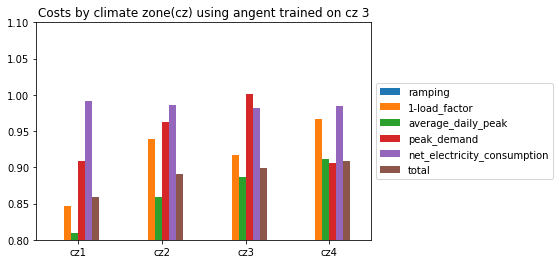

In [ ]:
df = pd.read_csv("/gdrive/My Drive/eval_baseline_cz3.csv", index_col=0)
ax = df.plot.bar(rot=0)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylim((0.8, 1.1))
plt.title("Costs by climate zone(cz) using angent trained on cz 3")
pass

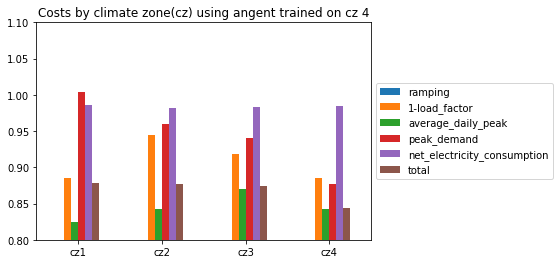

In [ ]:
df = pd.read_csv("/gdrive/My Drive/eval_baseline_cz4.csv", index_col=0)
ax = df.plot.bar(rot=0)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylim((0.8, 1.10))
plt.title("Costs by climate zone(cz) using angent trained on cz 4")
pass